In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook.mplstyle')
%matplotlib inline

from scipy.integrate import quad
from scipy.interpolate import interp1d

Computers can generate (pseudo)-random, uniformly distributed random numbers (using, e.g., the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister)). We often want to generate random samples from distributions, either with analytic forms or complex posterior probabilities. For some distributions, there are specific algorithms that efficiently generate samples (e.g., Box-Mueller for the Gaussian) -- for named distributions, you should almost always use [scipy.stats](https://docs.scipy.org/doc/scipy-0.18.1/reference/stats.html)! -- but in other cases, you'll need to generate samples numerically. Here we'll go through a few methods for doing that.

---

# Inverse transform sampling

Only works for 1D or separable ND distributions.

Given some (probability, number, mass) density function $p(x)$ compute the cumulative distribution:
$$
F(x) = \int_{-\infty}^x \, p(z) \, {\rm d}z
$$

To generate samples from $x \sim p(x)$, generate uniform random samples $u$ and invert the cdf:
$$
x = F^{-1}(u)
$$

Let's see this in action.

### Example 1: points uniformly distributed on the surface of a unit sphere

Generate 1000 angular positions $(\phi, \theta)$ on the surface of the unit sphere, uniformly distributed over the surface. 

Do this by analytically inverting the cdf, generating uniform random samples, and evaluating:

In [2]:
phi = np.random.uniform(0, 2*np.pi, size=10000)
theta = np.arccos(2*np.random.uniform(size=10000) - 1) 

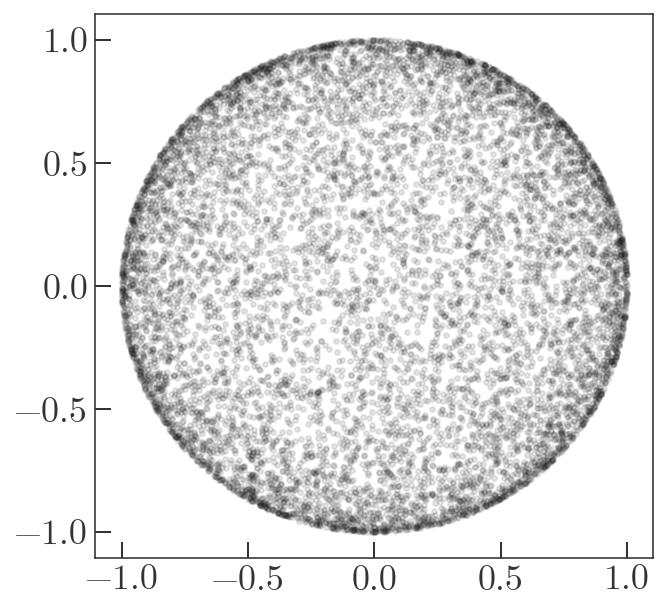

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(np.cos(phi)*np.sin(theta), 
            np.sin(phi)*np.sin(theta), 
            alpha=0.1, marker='.')

### Example 2: points drawn from a power-law distribution

$$
\begin{align}
p(x) &= C \, x^n\\
\quad x &\in (a, b)\\
n&<0\\
C &= \frac{1 + n}{b^{1+n} - a^{1+n}}
\end{align}
$$

Generate 1000 points drawn from a power-law distribution with the following parameters:
$$
n = -2\\
a = 0.1\\
b = 10.
$$

Do this by _numerically_ computing the cdf along a grid of values over the domain $(0.1,10.)$. 

Hint: use scipy's integration function `quad()` and use an interpolating function, scipy's `interp1d()`, to invert the cdf. Both are already imported

In [4]:
a = 0.1
b = 10.
n = -2.

In [5]:
def power_law_pdf(x):
    C = (1+n) / (b**(1+n) - a**(1+n))
    return C*x**n

In [6]:
quad(power_law_pdf, a, b)

(0.9999999999999999, 3.038479026730819e-09)

In [7]:
x_grid = np.linspace(a, b, 1024)
power_law_cdf = [quad(power_law_pdf, a, x)[0] for x in x_grid]

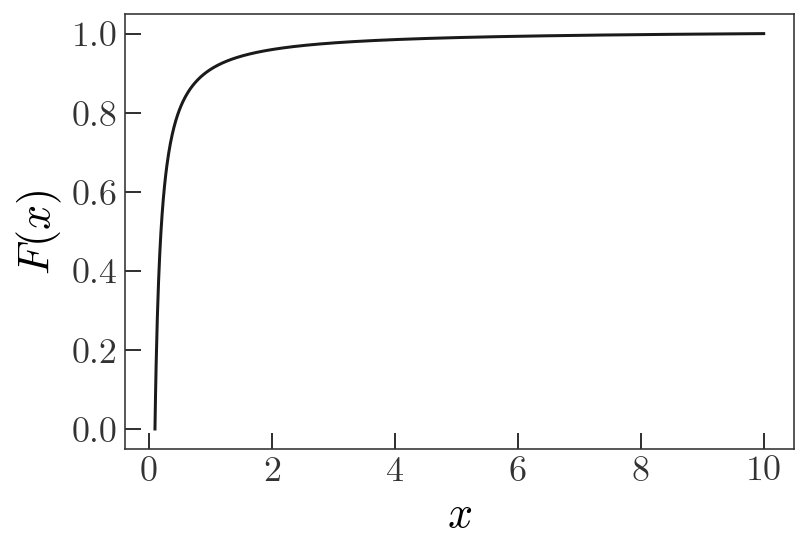

In [8]:
plt.plot(x_grid, power_law_cdf, marker='');
plt.xlabel(r'$x$')
plt.ylabel(r'$F(x)$')

In [9]:
func = interp1d(power_law_cdf, x_grid)

In [10]:
xs = func(np.random.uniform(size=10000))

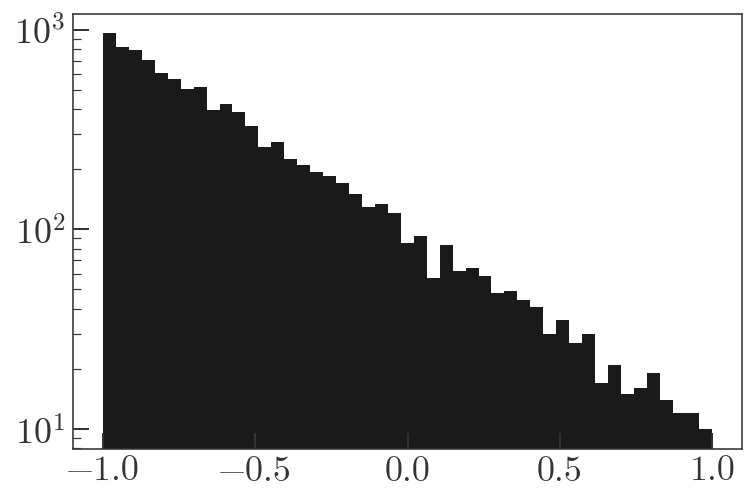

In [11]:
plt.hist(np.log10(xs), bins='auto');
plt.yscale('log')

### Example 3: radii drawn from a Hernquist profile

$$
\begin{align}
\rho(r) &= \frac{M_{tot}}{2\pi\,a^3} \, \left[\frac{r}{a} \, \left(1+\frac{r}{a}\right)^3\right] \\
M(<r) &= 2\,M_{tot} \, \frac{\left(r/a\right)^2}{2\left(1 + r/a\right)^2}
\end{align}
$$

Use whatever method you prefer to sample 1000 radii from a Hernquist profile.

---

# Rejection sampling

Only practical for low dimensionality.

### Example 1: sampling from a mixture of two Gaussians

Use rejection sampling to generate approximate samples from the mixture of Gaussians $\mathcal(N)(\mu,\sigma^2)$ defined by (and below):
$$
p(x) = 0.5\,\mathcal{N}(1,0.25) + 0.5\,\mathcal{N}(2.5,1)
$$

In [12]:
def gaussian(x, mu, var):
    return 1/np.sqrt(2*np.pi*var) * np.exp(-0.5*(x-mu)**2/var)

def gaussian_mixture(x):
    return 0.5*gaussian(x, 1., 0.25) + 0.5*gaussian(x, 2.5, 1)

First plot the pdf of the mixture

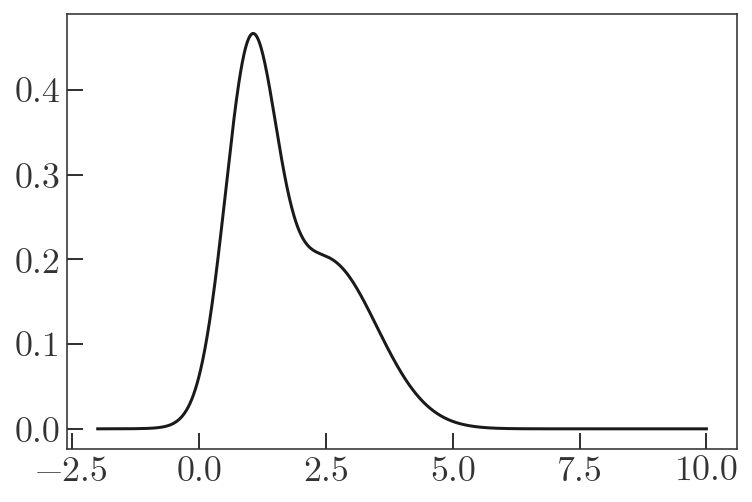

In [13]:
x_grid = np.linspace(-2, 10, 1024)
plt.plot(x_grid, gaussian_mixture(x_grid), marker='')

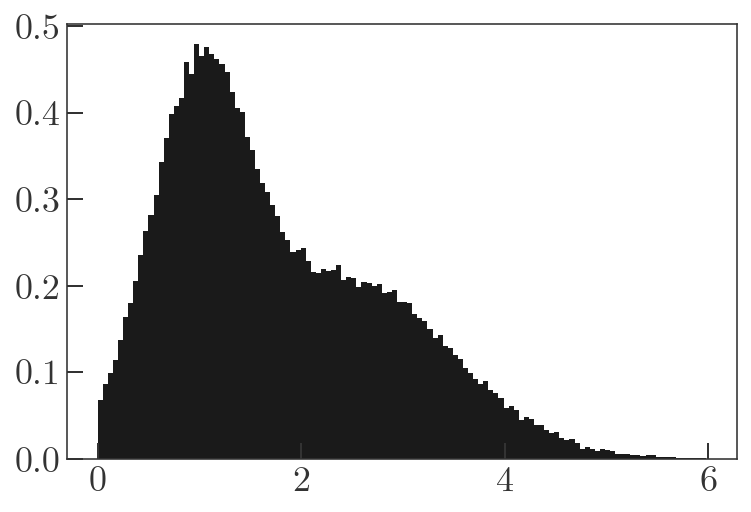

In [14]:
import numpy.random as rand

n_sample = 500000
x_sample = 6.*rand.random(n_sample)
y_sample = 0.5*rand.random(n_sample)

x_to_keep=[]
for i in range(n_sample):
    if y_sample[i] < gaussian_mixture(x_sample[i]):
        x_to_keep.append(x_sample[i])
        
plt.hist(x_to_keep,bins=120,normed=True);

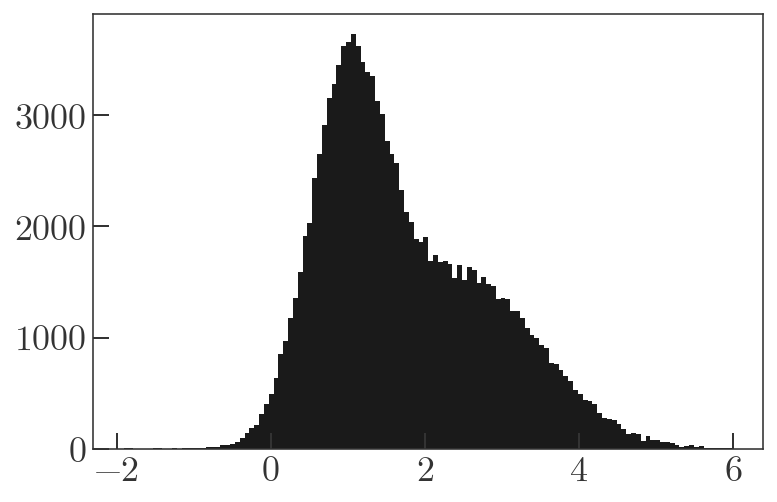

In [15]:
N = 500000
x_sample = np.random.uniform(-2, 6, size=N)
y_sample = np.random.uniform(0, 0.5, size=N)

idx = y_sample < gaussian_mixture(x_sample)
x = x_sample[idx]

n,_,_ = plt.hist(x, bins='auto')

(Comment on adaptive rejection sampling methods)

___

# Markov Chain Monte Carlo (MCMC): Metropolis-hastings

Lose independent samples, gain in scalability to higher dimensions

The simplest MCMC algorithm is "Metropolis-Hastings". I'm not going to explain it in detail, but in pseudocode, it looks like this:

- Start from some position in the space of variables you are sampling over, $\theta_0$ with probability $\pi_0$
- Iterate from 1 to $N_{\rm steps}$:
    - Sample an offset from $\delta\theta_0$ from some proposal distribution
    - Compute a new parameter value using this offset, $\theta_{\rm new} = \theta_0 + \delta\theta_0$
    - Evaluate the probability at the new parameter vector, $\pi_{\rm new}$
    - Sample a uniform random number, $r \sim \mathcal{U}(0,1)$
    - if $\pi_{\rm new}/\pi_0 > 1$ or $\pi_{\rm new}/\pi_0 > r$:
        - store $\theta_{\rm new}$
        - replace $\theta_0,\pi_0$ with $\theta_{\rm new},\pi_{\rm new}$
    - else:
        - store $\theta_0$ again
        
The proposal distribution has to be chosen and tuned by hand. We'll use a spherical / uncorrelated Gaussian distribution with root-variances set by hand.

### Example 1: implement and use Metropolis-Hastings MCMC to sample from the above mixture of Gaussians

In [16]:
from scipy.misc import logsumexp

In [17]:
# First, here's a log version of the mixture of Gaussians above that 
#    is less sensitive to numerical issues

def ln_gaussian(x, mu, var):
    return -0.5*np.log(2*np.pi*var) - 0.5*(x-mu)**2/var

def ln_gaussian_mixture(x):
    x = np.atleast_1d(x)
    
    # weights
    w = np.array([0.5, 0.5])[:,np.newaxis]
    
    X = np.vstack((ln_gaussian(x, 1., 0.25), ln_gaussian(x, 2.5, 1)))
    return logsumexp(X, b=w, axis=0)

In [18]:
ln_gaussian_mixture(1.)

array([-0.76851516])

In [19]:
# We're sampling from a 1D distribution, so we only need to propose in 1 dimension
def sample_proposal(sigma):
    return np.random.normal(0., sigma)

In [20]:
def run_metropolis_hastings_1d(p0, n_steps, ln_prob_func, proposal_sigma):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : numeric
        Initial value.
    n_steps : int
        Number of steps to run the sampler for.
    ln_prob_func : function
        A callable object that computes the log takes a parameter vector and computes 
        the log of the posterior pdf.
    proposal_sigmas : numeric
        Standard-deviation passed to the sample_proposal function. 
    """
    
    # the objects we'll fill and return:
    chain = np.zeros(n_steps) #  value at each step
    ln_probs = np.zeros(n_steps) # log-probability value at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = ln_prob_func(p0)
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,n_steps):
        # proposed new parameters
        step = sample_proposal(proposal_sigma)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = ln_prob_func(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

In [21]:
# Run the MCMC sampler to generate samples from the mixture of Gaussians 

In [22]:
chain,ln_probs,acc_frac = run_metropolis_hastings_1d(-5., 
                                                     10000, 
                                                     ln_gaussian_mixture, 
                                                     2.5)

In [23]:
acc_frac

0.4278

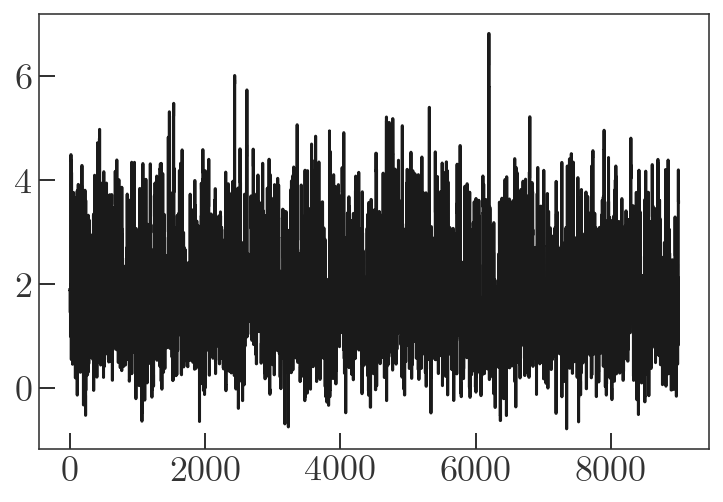

In [24]:
plt.plot(chain[1000:], marker='', drawstyle='steps-mid')

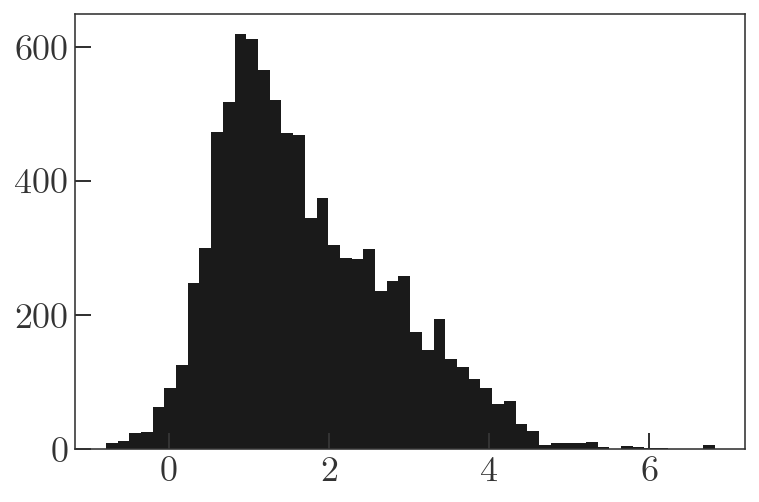

In [25]:
plt.hist(chain[1000:], bins='auto');